<a href="https://colab.research.google.com/github/styxx216/ML/blob/main/DiagramClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python

In [ ]:
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torch.nn.functional as F
import copy
import tqdm
import time
from PIL import Image
import random
import albumentations
from albumentations import pytorch as AT
import torchvision.models as models
from torch import nn, optim

%matplotlib inline

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/My Drive/DATASET_KAGGLE'

train_files = os.listdir(train_dir)


In [ ]:
class ChartsDataset(Dataset):
    
    def __init__(self, path, img_list, transform=None, mode='train'):
        self.path = path
        self.img_list = img_list
        self.transform=transform
        self.mode = mode


    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        image_name ="//"+ self.img_list[idx]

        image = cv2.imread(os.path.join(self.path, image_name))
        
        if image_name.split(".")[1] == "gif":
           gif = cv2.VideoCapture(self.path + image_name)
           _, image = gif.read()
        else:
            image = cv2.imread(self.path + image_name)
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label=np.array([1,0,0,0,0,0,0,0],dtype=np.float32)
        if "bar_chart" in image_name:
            label = 1
            label=np.array([0,1,0,0,0,0,0,0],dtype=np.float32)
        elif "diagram" in image_name:
            label = 2
            label=np.array([0,0,1,0,0,0,0,0],dtype=np.float32)
        elif "flow_chart" in image_name:
            label = 3
            label=np.array([0,0,0,1,0,0,0,0],dtype=np.float32)
        elif "graph" in image_name:
            label = 4
            label=np.array([0,0,0,0,1,0,0,0],dtype=np.float32)
        elif "growth_chart" in image_name:
            label = 5
            label=np.array([0,0,0,0,0,1,0,0],dtype=np.float32)
        elif "pie_chart" in image_name:
            label = 6
            label=np.array([0,0,0,0,0,0,1,0],dtype=np.float32)
        elif "table" in image_name:
            label = 7
            label=np.array([0,0,0,0,0,0,0,1],dtype=np.float32)
        else:
            label = 0
            label=np.array([1,0,0,0,0,0,0,0],dtype=np.float32)


        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        
        if self.mode == "train":
            return image, label
        else:
            return image, self.img_list[idx]

In [ ]:
#Пример того как выглядит обычно набор аугментаций. 
#В зависимости от задачи может отличаться количеством и сложностью.
img_size=256
data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    albumentations.RandomCrop(p=0.2,height=img_size,width=img_size),
    albumentations.RGBShift(p=0.1),
    
    albumentations.RandomContrast(p=0.2),
    albumentations.RandomBrightness(p=0.2),
    albumentations.Cutout(p=0.3),
    AT.ToTensor()
    ])

#обычно аугментации для трейн и тест датасетов разделают. 
#На тесте обычно не нужно сильно изменять изображения
data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    # albumentations.HorizontalFlip(),
    # albumentations.RandomRotate90(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

In [ ]:
test_dir='/content/drive/My Drive/test/test'
test_files = os.listdir(test_dir)

In [ ]:
testset = ChartsDataset(test_dir,test_files,transform=data_transforms_test,mode='test')

In [ ]:
trainset = ChartsDataset(train_dir,train_files,transform=data_transforms)


In [ ]:
#Разделим трейновую часть на трейн и валидацию. Попробуем другой способ.
valid_size = int(len(trainset) * 0.1)
train_set, valid_set = torch.utils.data.random_split(trainset, 
                                    (len(trainset)-valid_size, valid_size))

In [ ]:
len(train_set), len(valid_set)

(15134, 1681)

In [ ]:
#зададим немного гиперпараметров
batch_size = 8
num_workers = 0
img_size = 256

In [ ]:
testloader=torch.utils.data.DataLoader(testset, pin_memory=True, 
                                        batch_size=1, shuffle=False)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0.]])


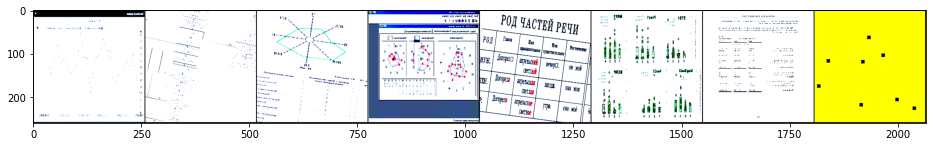

In [ ]:
#Проверим работоспособность
samples, labels = next(iter(trainloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
print(labels)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
lr = 0.1
n_epoch = 10


model = torchvision.models.resnet50(pretrained=True)
#, progress=True)

#model.load_state_dict(torch.load('/content/drive/My Drive/resnet50.pth'))
# for param in model.parameters():
#     param.requires_grad = False

model.fc= nn.Linear(2048, 8)
model=model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
print(model)

In [ ]:
model.train()
train_loss = []
train_losses = []
for epoch in range(n_epoch):
    
    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()       
        optimizer.step()

        train_loss.append(loss.item())
    scheduler.step(np.mean(train_loss))


    print(f" Номер эпохи: {epoch+1}, Трейн лосс: {np.mean(train_loss)}, Текущий лернинг рейт: {optimizer.param_groups[0]['lr']} ")
    train_losses.append(np.mean(train_loss))


 Номер эпохи: 1, Трейн лосс: 0.011722020017900419, Текущий лернинг рейт: 0.001 
 Номер эпохи: 2, Трейн лосс: 0.01154214115675864, Текущий лернинг рейт: 0.001 
 Номер эпохи: 3, Трейн лосс: 0.011744462310007761, Текущий лернинг рейт: 0.001 
 Номер эпохи: 4, Трейн лосс: 0.011802759891888778, Текущий лернинг рейт: 0.001 
 Номер эпохи: 5, Трейн лосс: 0.011976469649422993, Текущий лернинг рейт: 0.0005 
 Номер эпохи: 6, Трейн лосс: 0.012012401819671253, Текущий лернинг рейт: 0.0005 
 Номер эпохи: 7, Трейн лосс: 0.01199722273797344, Текущий лернинг рейт: 0.0005 
 Номер эпохи: 8, Трейн лосс: 0.012010673783218713, Текущий лернинг рейт: 0.00025 
 Номер эпохи: 9, Трейн лосс: 0.012025967244211995, Текущий лернинг рейт: 0.00025 
 Номер эпохи: 10, Трейн лосс: 0.011983000568222718, Текущий лернинг рейт: 0.00025 


In [ ]:
torch.save(model,'/content/drive/My Drive/adam_densenet201_40.pth')

In [ ]:




model.train()
train_loss = []
train_losses = []
for epoch in range(n_epoch):
    
    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()       
        optimizer.step()

        train_loss.append(loss.item())
    scheduler.step(np.mean(train_loss))


    print(f" Номер эпохи: {epoch+1}, Трейн лосс: {np.mean(train_loss)}, Текущий лернинг рейт: {optimizer.param_groups[0]['lr']} ")
    train_losses.append(np.mean(train_loss))


torch.save(model,'/content/drive/My Drive/adam_2_resnet50_10.pth')


model.train()
train_loss = []
train_losses = []
for epoch in range(n_epoch):
    
    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()       
        optimizer.step()

        train_loss.append(loss.item())
    scheduler.step(np.mean(train_loss))


    print(f" Номер эпохи: {epoch+1}, Трейн лосс: {np.mean(train_loss)}, Текущий лернинг рейт: {optimizer.param_groups[0]['lr']} ")
    train_losses.append(np.mean(train_loss))


torch.save(model,'/content/drive/My Drive/adam_2_resnet50_20.pth')



model.train()
train_loss = []
train_losses = []
for epoch in range(n_epoch):
    
    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()       
        optimizer.step()

        train_loss.append(loss.item())
    scheduler.step(np.mean(train_loss))


    print(f" Номер эпохи: {epoch+1}, Трейн лосс: {np.mean(train_loss)}, Текущий лернинг рейт: {optimizer.param_groups[0]['lr']} ")
    train_losses.append(np.mean(train_loss))


torch.save(model,'/content/drive/My Drive/adam_2_resnet50_30.pth')


model.train()
train_loss = []
train_losses = []
for epoch in range(n_epoch):
    
    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()       
        optimizer.step()

        train_loss.append(loss.item())
    scheduler.step(np.mean(train_loss))


    print(f" Номер эпохи: {epoch+1}, Трейн лосс: {np.mean(train_loss)}, Текущий лернинг рейт: {optimizer.param_groups[0]['lr']} ")
    train_losses.append(np.mean(train_loss))


torch.save(model,'/content/drive/My Drive/adam_2_resnet50_40.pth')

 Номер эпохи: 1, Трейн лосс: 0.24707342250111175, Текущий лернинг рейт: 0.001 
 Номер эпохи: 2, Трейн лосс: 0.2012552041914826, Текущий лернинг рейт: 0.001 
 Номер эпохи: 3, Трейн лосс: 0.17651983934019477, Текущий лернинг рейт: 0.001 
 Номер эпохи: 4, Трейн лосс: 0.1609072833745071, Текущий лернинг рейт: 0.001 
 Номер эпохи: 5, Трейн лосс: 0.15002298983828957, Текущий лернинг рейт: 0.001 
 Номер эпохи: 6, Трейн лосс: 0.14171854098697625, Текущий лернинг рейт: 0.001 
 Номер эпохи: 7, Трейн лосс: 0.13477181563367216, Текущий лернинг рейт: 0.001 
 Номер эпохи: 8, Трейн лосс: 0.12898058589113098, Текущий лернинг рейт: 0.001 
 Номер эпохи: 9, Трейн лосс: 0.12432019414667006, Текущий лернинг рейт: 0.001 
 Номер эпохи: 10, Трейн лосс: 0.12013293106516727, Текущий лернинг рейт: 0.001 
 Номер эпохи: 1, Трейн лосс: 0.0820578317381033, Текущий лернинг рейт: 0.001 
 Номер эпохи: 2, Трейн лосс: 0.08067488106122452, Текущий лернинг рейт: 0.001 
 Номер эпохи: 3, Трейн лосс: 0.07924886075556953, Теку

In [ ]:
test_dir = '/content/drive/My Drive/test/test'

test_files = os.listdir(test_dir)

In [ ]:
model=torch.load('/content/drive/My Drive/adam_resnet50_30.pth')
model=model.to(device)


In [ ]:
data_test = pd.read_csv('/content/drive/My Drive/sample_submission.csv',  # Это то, куда вы скачали файл
                       sep=',', encoding='latin1',
                       dayfirst=True)
test_labels=data_test['label']
test_labels=test_labels.values.tolist()
test_names=data_test['image_name']
test_names=test_names.values.tolist()


In [ ]:
testset = ChartsDataset(test_dir,test_files,transform=data_transforms_test,mode='test')

In [ ]:
testloader = torch.utils.data.DataLoader(testset, pin_memory=True, 
                                        batch_size=1, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['74e491b0-a239-4dba-af24-1c71e7032ff1.png']


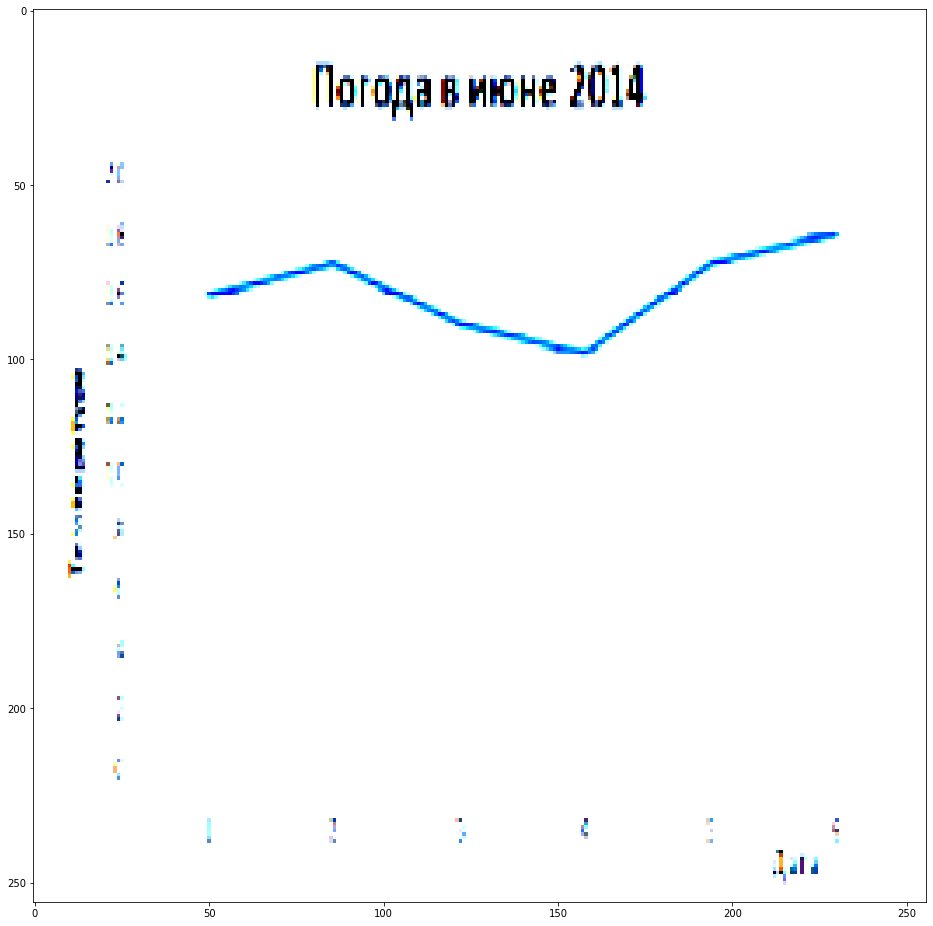

In [ ]:
#Проверим работоспособность
samples, labels = next(iter(testloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
print(labels)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([5, 1, 4, 7, 7, 2, 4, 1, 3, 1, 0, 0, 3, 1, 5, 4, 7, 0, 3, 3, 7, 7, 5, 0,
        1, 4, 2, 4, 2, 3, 2, 1], device='cuda:0')
tensor([5, 1, 4, 7, 7, 2, 7, 7, 3, 1, 0, 0, 3, 1, 5, 4, 7, 0, 3, 3, 7, 7, 5, 0,
        4, 3, 7, 4, 2, 3, 2, 1], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4, 7, 0, 7, 7, 2, 7, 2, 3, 2, 4, 2, 3, 7, 7, 3, 1, 0, 4, 0, 2, 3, 0, 0,
        4, 3, 2, 3, 4, 7, 0, 3], device='cuda:0')
tensor([4, 7, 0, 7, 7, 2, 7, 2, 3, 2, 3, 2, 3, 7, 7, 3, 1, 0, 4, 0, 2, 3, 0, 0,
        4, 3, 2, 3, 5, 7, 0, 3], device='cuda:0')


KeyboardInterrupt: ignored

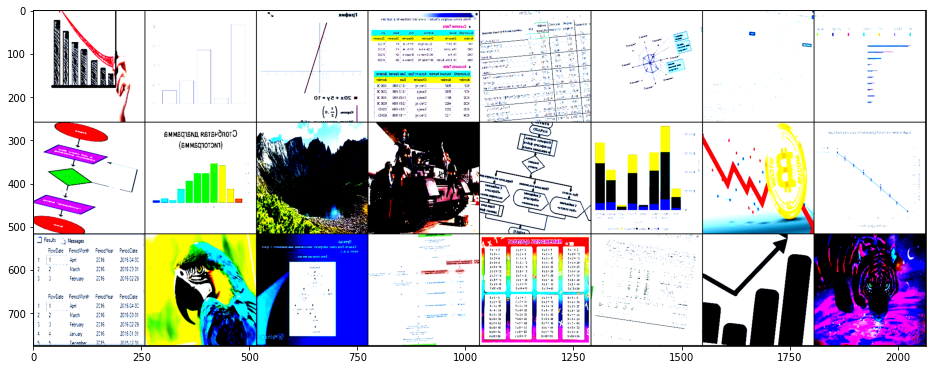

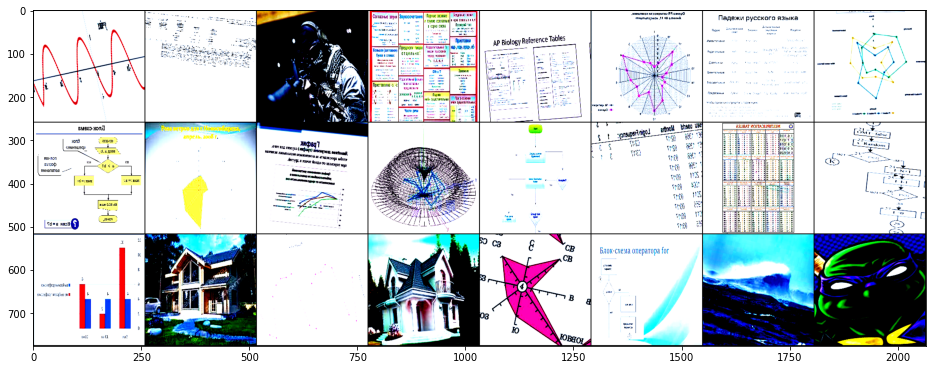

In [ ]:
model.eval()
correct = 0
i=0
with torch.no_grad():
  
  for data, target in trainloader:
    i+=1
    plt.figure(figsize=(16,24))
    grid_imgs = torchvision.utils.make_grid(data[:24])
    np_grid_imgs = grid_imgs.numpy()
    # in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.

    plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
    
    data = data.to(device=device)
    target = target.to(device=device)
    a, target= torch.max(target.data, 1)
    outputs = model(data)
    a, predicted = torch.max(outputs.data, 1)

    predicted=predicted
    print(target)
    print(predicted)


    


    correct += (predicted == target).sum().item()


acc = correct / len(trainset)
print(f'Accuracy on test set: {acc}')

In [ ]:
df = pd.DataFrame()

In [ ]:
print(df)

Empty DataFrame
Columns: []
Index: []


In [ ]:
labels=[]
names=[]

In [ ]:
model.eval()
correct = 0
i=0
with torch.no_grad():
  
  for data, target in testloader:
    i+=1
    print(i)
    target=target[0]
    data = data.to(device=device)

    outputs = model(data)

    a, predicted = torch.max(outputs.data, 1)

    predicted=int(predicted[0])
    names.append(target)
    labels.append(predicted)
    print(target)
    print(predicted)


    




Выходные данные были обрезаны до нескольких последних строк (5000).
0
88
7e717e6d-c8c9-49d7-a4c1-fe1a9dec6a57.jpg
1
89
7914bd0c-c962-4fb6-9ec5-4ca6bea826c0.jpg
0
90
7b4a0e90-2ca0-4990-b9e8-0ff10780b4a5.jpg
3
91
7969a217-7f12-4811-a6a9-b795456c8f74.jpg
5
92
78293a41-e42a-49a3-924a-d4291cb8db62.png
4
93
778c6def-0d6e-41cb-ae28-308e256f8c9c.jpg
0
94
7af1be2f-b318-4f95-8768-606858af3e08.jpg
2
95
7d996197-db09-4833-b010-83c2ecafdc70.jpg
2
96
79ede01e-c7fd-45a5-8614-5d985d113357.jpg
0
97
78e97fd6-e8c5-4fcb-a0b0-9f440ba9e3a5.jpg
2
98
7b19f210-c23f-467e-8ef0-498e4fba189b.jpg
2
99
79bad3c7-3d97-4a39-b729-f24a2b12cac8.jpg
2
100
776b910c-089e-4cbe-9910-498b01db088c.jpg
2
101
77e5b2b2-aff3-4467-924b-79aecb523785.jpg
3
102
7a139aeb-2f8c-48c2-978a-d7141f319820.jpg
1
103
77e04e0d-336e-47fa-9600-9aba5f9c0529.jpg
3
104
7b109df0-a401-442f-9766-11af8e1cc701.jpg
2
105
79616674-75e3-43b4-bff2-77ec3d7e2df0.jpg
3
106
7a8897ef-606c-47b1-904e-72fed4348007.jpg
2
107
7c7574a5-9595-4fe9-ac9d-11e850cfa8ed.jpg
0
10

In [ ]:
data = {'image_name':names, 'label':labels}
df = pd.DataFrame(data)
print(df)

                                    image_name  label
0     74e491b0-a239-4dba-af24-1c71e7032ff1.png      4
1     722bc4a6-a191-4804-b8f9-4300ca5f1d3f.jpg      3
2     72de8b1b-5e1b-4e35-934a-29b40a6c9eb9.jpg      0
3     764b2e74-099b-4573-a879-2f7d0d4dbaa4.jpg      7
4     7052be1f-3f63-474f-aaf7-c2abc0956de3.jpg      3
...                                        ...    ...
1748  6fb7a118-2c3a-4929-a731-2632f9dfb00a.jpg      7
1749  71d2a6ab-0133-4368-96af-00614f9cbab0.jpg      2
1750  6dec2606-973a-433c-818b-0bd90b536daf.jpg      0
1751  73b66d56-b257-4e4e-a789-64b658095d77.jpg      0
1752  73bdca89-2024-4f54-87ce-adac85734103.jpg      0

[1753 rows x 2 columns]


In [ ]:
df.to_csv('/content/drive/My Drive/file24.csv', index=False)